## Assignment 1
### Stochastic Simulation

**Team 6**:
- Yuxin Dong - 15550397
- Marcell Szegedi - 15722635
- Koen Verlaan - 11848316

**Git Fame**

Total commits: 22
Total ctimes: 197
Total files: 15
Total loc: 215880
| Author          |    loc |   coms |   fils |  distribution   |
|:----------------|-------:|-------:|-------:|:----------------|
| MarcellSzegedi  | 213198 |      6 |      8 | 98.8/27.3/53.3  |
| Yuxin Dong      |   2660 |     13 |      5 | 1.2/59.1/33.3   |
| Marcell Szegedi |     22 |      3 |      2 | 0.0/13.6/13.3   |

**GitHub URL**: https://github.com/MarcellSzegedi/Stochastic_Simulation_I..git

**Import Libraries**

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from scipy.stats import qmc
from scipy.stats.qmc import LatinHypercube
from concurrent.futures import ThreadPoolExecutor
from scipy.stats import linregress
from scipy.stats import norm, f, ttest_ind

**Global Folders**

In [5]:
lib_task_1 = r"Figures/Task 1"
lib_task_2 = r"Figures/Task 2"
lib_task_3 = r"Figures/Task 3"
lib_task_4 = r"Figures/Task 4"

---
## 1. Implementing and Visualizing Different Sampling Techniques

- Define the function that let's us randomly sample in three different ways:
    - Pure Random Sampling
    - Latin Hypercube Sampling
    - Orthogonal Sampling
- Define the funciton that determines whether a complex number is part of the Mandelbrot set or not, using predetrmined finite amount of iteration

##### Support Functions

In [ ]:
# Define Mandelbrot set calculation function
def mandelbrot(point: complex, max_iter: int =1000) -> int:
    z = 0
    for i in range(max_iter):
        z = z**2 + point
        if abs(z) > 2:
            return i
    return max_iter


# Define the random sampling function
def random_sample(n: int, x_range: tuple, y_range: tuple, sampler: str ='pure_random_sampling') -> np.ndarray:
    match sampler:
        case 'pure_random_sampling':
            # Pure random sampling
            x_coords = np.random.uniform(x_range[0], x_range[1], n)
            y_coords = np.random.uniform(y_range[0], y_range[1], n)
            points = np.stack((x_coords, y_coords), axis=-1)

        case 'latin_hypercube_sampling':
            # Latin Hypercube Sampling
            lhc = qmc.LatinHypercube(d=2)
            points = lhc.random(n)
            points[:, 0] = points[:, 0] * (x_range[1] - x_range[0]) + x_range[0]
            points[:, 1] = points[:, 1] * (y_range[1] - y_range[0]) + y_range[0]

        case 'orthogonal_sampling':
            n_bucket = int(np.sqrt(n))
            if np.power(n_bucket, 2) != n:
                raise ValueError(f'"n" must be a perfect square and {n} is not that')

            x_coord = np.linspace(x_range[0], x_range[1], n_bucket, endpoint=False)
            y_coord = np.linspace(y_range[0], y_range[1], n_bucket, endpoint=False)

            xv, yv = np.meshgrid(x_coord, y_coord)
            points = np.column_stack((xv.ravel(), yv.ravel()))

            x_random = (x_range[1] - x_range[0]) / n_bucket * np.random.rand(n)
            y_random = (y_range[1] - y_range[0]) / n_bucket * np.random.rand(n)

            points[:, 0] += x_random
            points[:, 1] += y_random
            
        case _:
            raise ValueError("Invalid sampler specified.")
    
    return np.array([complex(point[0], point[1]) for point in points])

##### Plots

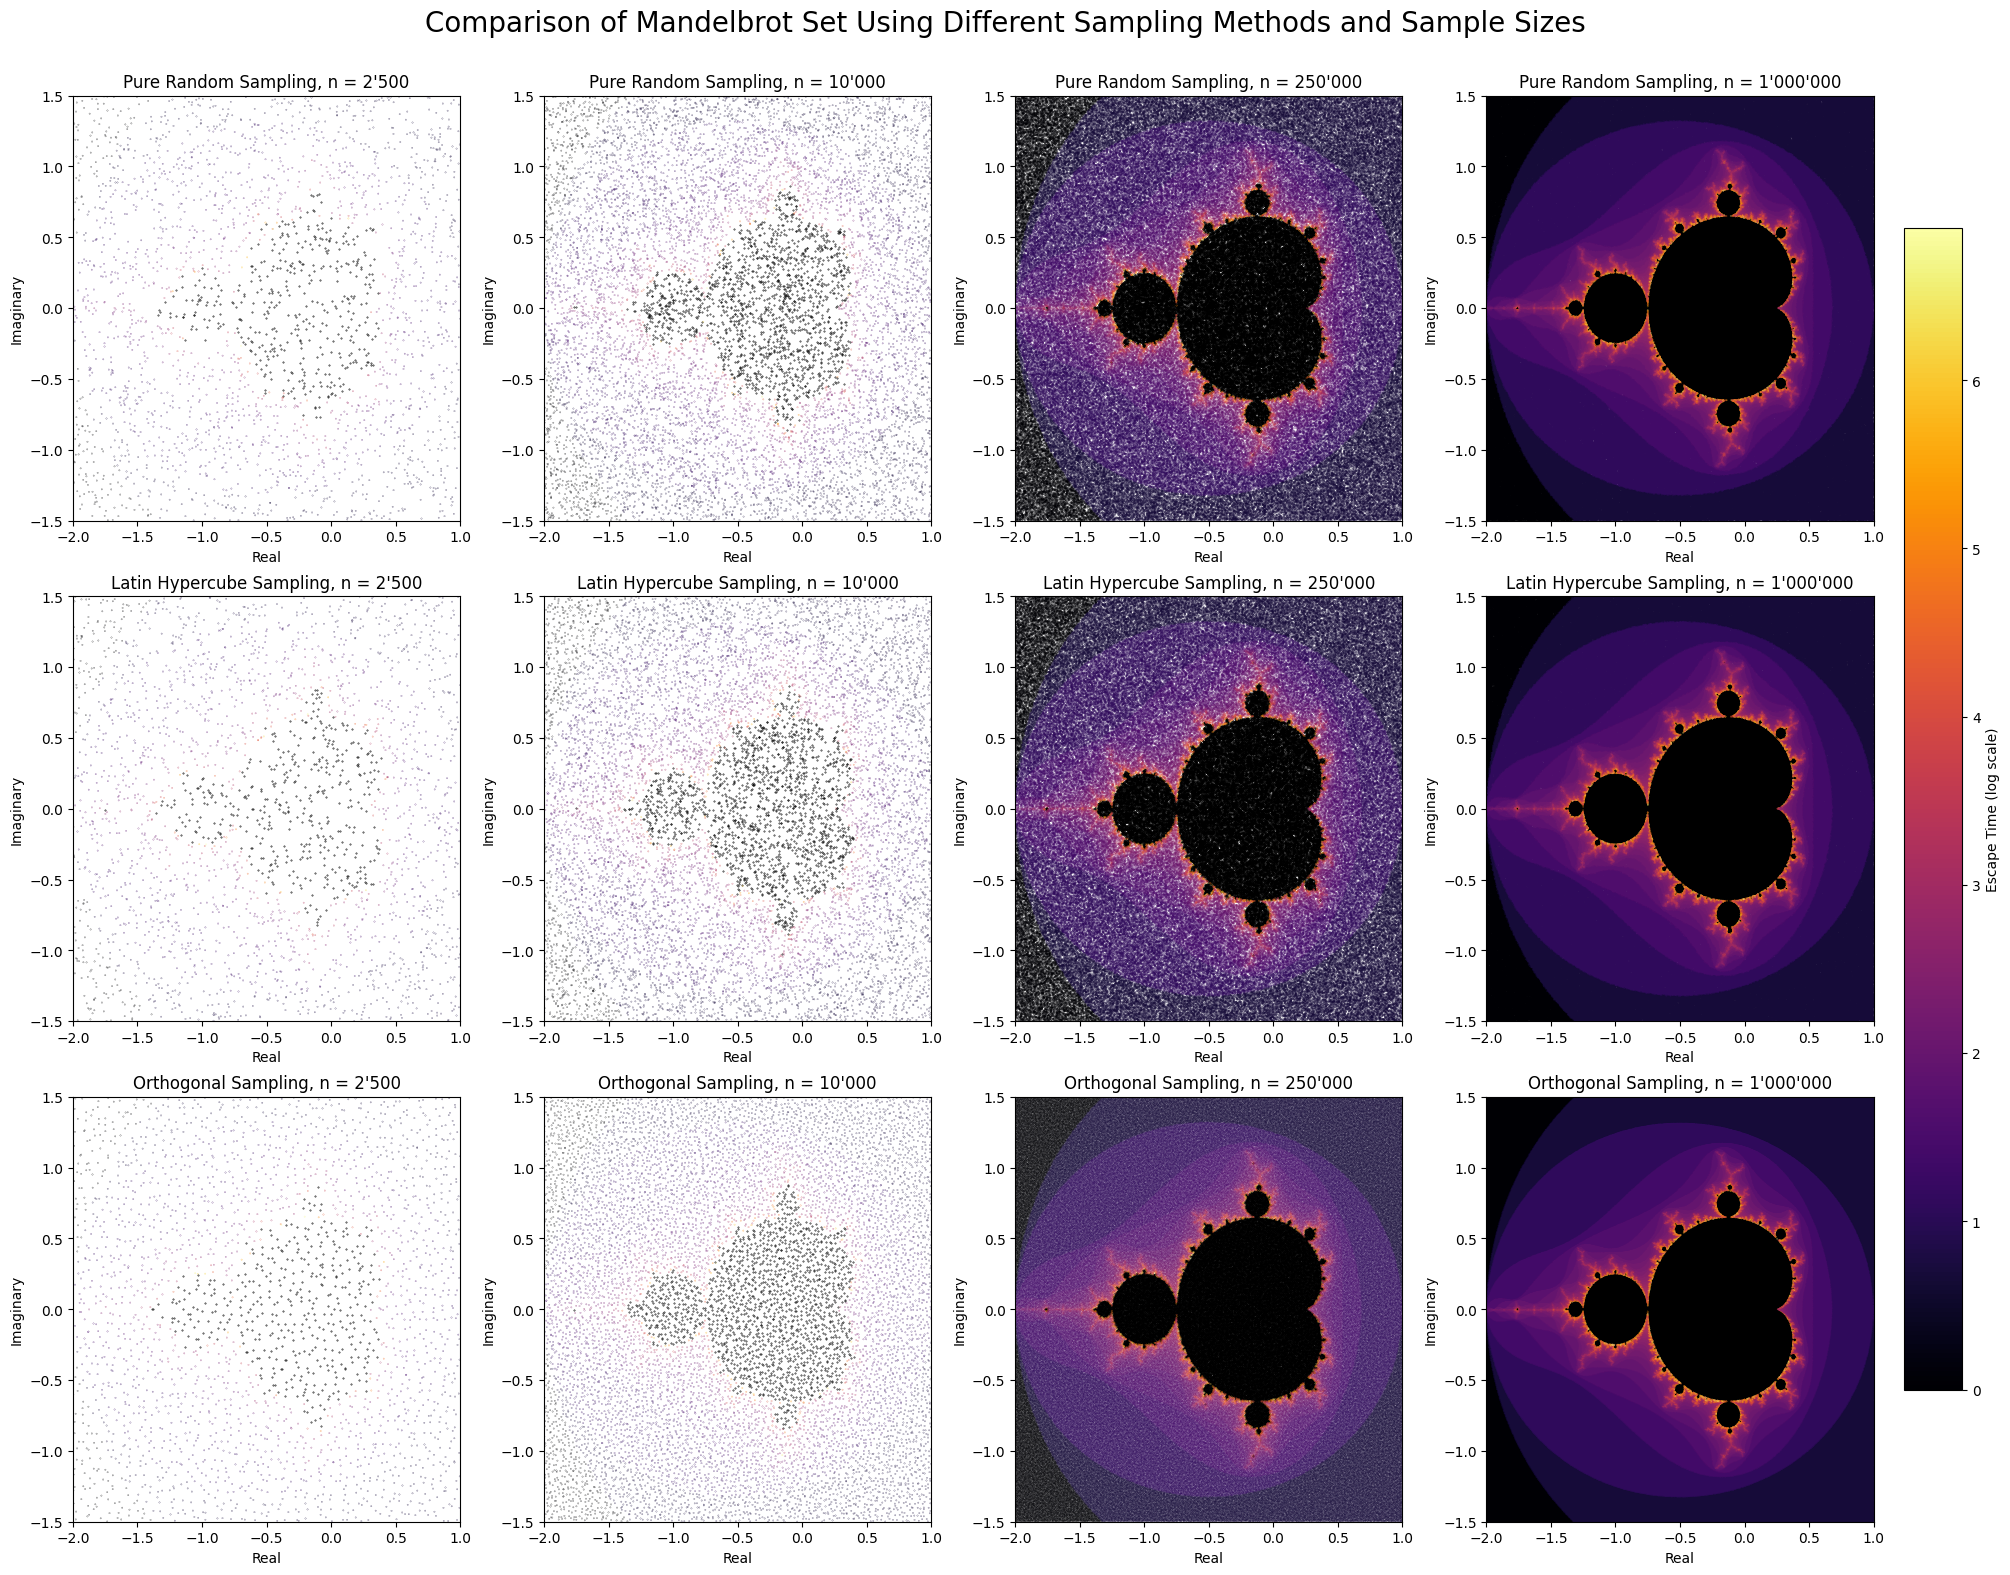

In [ ]:
# Plotting the different types of sampling techniques for different sample size
def plot_mandelbrot_subfig(n=10000, x_range=(-2, 1), y_range=(-1.5, 1.5), max_iter=1000, sampler='pure_random_sampling', ax=None):
    sample = random_sample(n, x_range, y_range, sampler)
    iterations = np.array([mandelbrot(point, max_iter) for point in sample])

    # Separate points inside and outside the Mandelbrot set
    in_set = iterations == max_iter
    outside_set = ~in_set

    # Use log-scaled colors for points outside the set
    colors = np.log(iterations + 1)

    # Plot on the provided axis
    ax.scatter(sample[in_set].real, sample[in_set].imag, color='black', s=0.5, marker='.')
    scatter = ax.scatter(sample[outside_set].real, sample[outside_set].imag,
                         c=colors[outside_set], cmap='inferno', s=0.1, marker='.')

    # Set plot details
    ax.set_xlim(x_range)
    ax.set_ylim(y_range)

    sample_title = f"n = {n:,}".replace(',', "'")
    if n % 10 != 0:
        sample_title = f"n ≈ {int(int(n / 100) * 100):,}".replace(',', "'")
    ax.set_title(f"{sampler.replace('_', ' ').title()}, {sample_title}")
    ax.set_xlabel("Real")
    ax.set_ylabel("Imaginary")
    return scatter

# Set up the subplots for comparing different sampling methods and sample sizes
fig, axes = plt.subplots(3, 4, figsize=(20, 15), constrained_layout=True)
fig.suptitle("Comparison of Mandelbrot Set Using Different Sampling Methods and Sample Sizes", fontsize=20, y=1.04)

# Define parameters
samplers = ['pure_random_sampling', 'latin_hypercube_sampling', 'orthogonal_sampling']
sample_sizes = [2500, 10000, 250000, 1000000]

# Plot for each sampler and sample size
for row, sampler in enumerate(samplers):
    for col, n in enumerate(sample_sizes):
        ax = axes[row, col]
        scatter = plot_mandelbrot_subfig(n, x_range=(-2, 1), y_range=(-1.5, 1.5), max_iter=1000, sampler=sampler, ax=ax)
        print(f"check n = {n} done")
    print(f"check sampler = {sampler} done")

# Add a color bar to the last axis for escaping points
fig.colorbar(scatter, ax=axes[:, -1], orientation='vertical', label="Escape Time (log scale)")

clear_output(wait=True)
plt.savefig(os.path.join(lib_task_3, "mandelbrot_pic_with_diff_sampling.png"), dpi=500)
plt.show()

---
## 2. Estimating the Mandelbrot Set Area and Accuracy

 - Using the sampling methods implemented in Part 1, we perform Monte Carlo integration to estimate the area of the Mandelbrot set, denoted by  $A_M$ .
 - Each sampling method generates an estimate  $A_{i,s}$ , where  $i$  is the number of iterations, and  $s$  is the sample size.
 - The accuracy of each method is calculated by comparing the estimated area  $A_{i,s}$  to the true area  $A_M$ , and the mean relative error is reported to evaluate each method’s accuracy.

##### Support Functions

In [7]:
# Pure Random Sampling
def monte_carlo_area_estimation(s: int, j: int, x_range: tuple, y_range: tuple, sampler: str) -> float:
    sample = random_sample(s, x_range, y_range, sampler)
    in_set_counter = np.sum([is_in_mandelbrot(number, j) for number in sample])
    return (in_set_counter / len(sample)) * (x_range[1] - x_range[0]) *(y_range[1] - y_range[0])


# Calculate the integral estimation for different iteration numbers smaller than the max iteration number
def calc_effect_of_number_iter(s: int, j_max: int, x_range: tuple, y_range: tuple, sampler: str, k: int = 100, start_j: int = 1) -> np.ndarray:
    if start_j * 0.5 > j_max:
        raise ValueError("Starting iteration number is too high.")
    iter_numbers = np.arange(start_j, j_max + k, k)
    area_estimations = np.array([monte_carlo_area_estimation(s, actual_iter, x_range, y_range, sampler) for actual_iter in iter_numbers])
    return iter_numbers, area_estimations


# Calculate the integral estimation for different sample sizes
def calc_effect_of_sample_size(s_max: int, j: int, x_range: tuple, y_range: tuple, sampler: str, k: int, start_s: int) -> np.ndarray:
    if start_s * 0.5 > s_max:
        raise ValueError("Starting sample size is too high.")
    sample_sizes = np.arange(start_s, s_max + k, k)
    area_estimations = np.array([monte_carlo_area_estimation(actual_sample_size, j, x_range, y_range, sampler) for actual_sample_size in sample_sizes])
    return sample_sizes, area_estimations


# Support functions
def is_in_mandelbrot(number: complex, iter_num: int) -> bool:
    return mandelbrot(number, iter_num) == iter_num

##### Calculations

In [18]:
# Parameters
s = 10000  # Sample size
j = 1000
x_range = (-2, 0.5)
y_range = (-1.25, 1.25)
true_area = 1.50659177  # Known area of the Mandelbrot set (for accuracy calculation)

# Monte Carlo area estimation using different sampling methods
area_random = monte_carlo_area_estimation(s, j, x_range, y_range, "pure_random_sampling")
area_lhs = monte_carlo_area_estimation(s, j, x_range, y_range, "latin_hypercube_sampling")
area_orthogonal = monte_carlo_area_estimation(s, j, x_range, y_range, "orthogonal_sampling")

# Print estimated areas
print("Estimated area using Pure Random Sampling:", area_random)
print("Estimated area using Latin Hypercube Sampling:", area_lhs)
print("Estimated area using Orthogonal Sampling:", area_orthogonal)

# Calculate relative accuracy (relative error) for each method
relative_error_random = np.abs((area_random - true_area) / true_area)
relative_error_lhs = np.abs((area_lhs - true_area) / true_area)
relative_error_orthogonal = np.abs((area_orthogonal - true_area) / true_area)

# Calculate absolute accuracy (absolute error) for each method
absolute_error_random = np.abs(area_random - true_area)
absolute_error_lhs = np.abs(area_lhs - true_area)
absolute_error_orthogonal = np.abs(area_orthogonal - true_area)

# Print accuracy results
print("Relative Error using Pure Random Sampling:", relative_error_random)
print("Relative Error using Latin Hypercube Sampling:", relative_error_lhs)
print("Relative Error using Orthogonal Sampling:", relative_error_orthogonal)

print("Absolute Error using Pure Random Sampling:", absolute_error_random)
print("Absolute Error using Latin Hypercube Sampling:", absolute_error_lhs)
print("Absolute Error using Orthogonal Sampling:", absolute_error_orthogonal)

Estimated area using Pure Random Sampling: 1.53625
Estimated area using Latin Hypercube Sampling: 1.49875
Estimated area using Orthogonal Sampling: 1.5031249999999998
Relative Error using Pure Random Sampling: 0.019685644506076055
Relative Error using Latin Hypercube Sampling: 0.005204973341915953
Relative Error using Orthogonal Sampling: 0.0023010679263170105
Absolute Error using Pure Random Sampling: 0.029658229999999897
Absolute Error using Latin Hypercube Sampling: 0.00784176999999997
Absolute Error using Orthogonal Sampling: 0.0034667700000001744


##### Plots

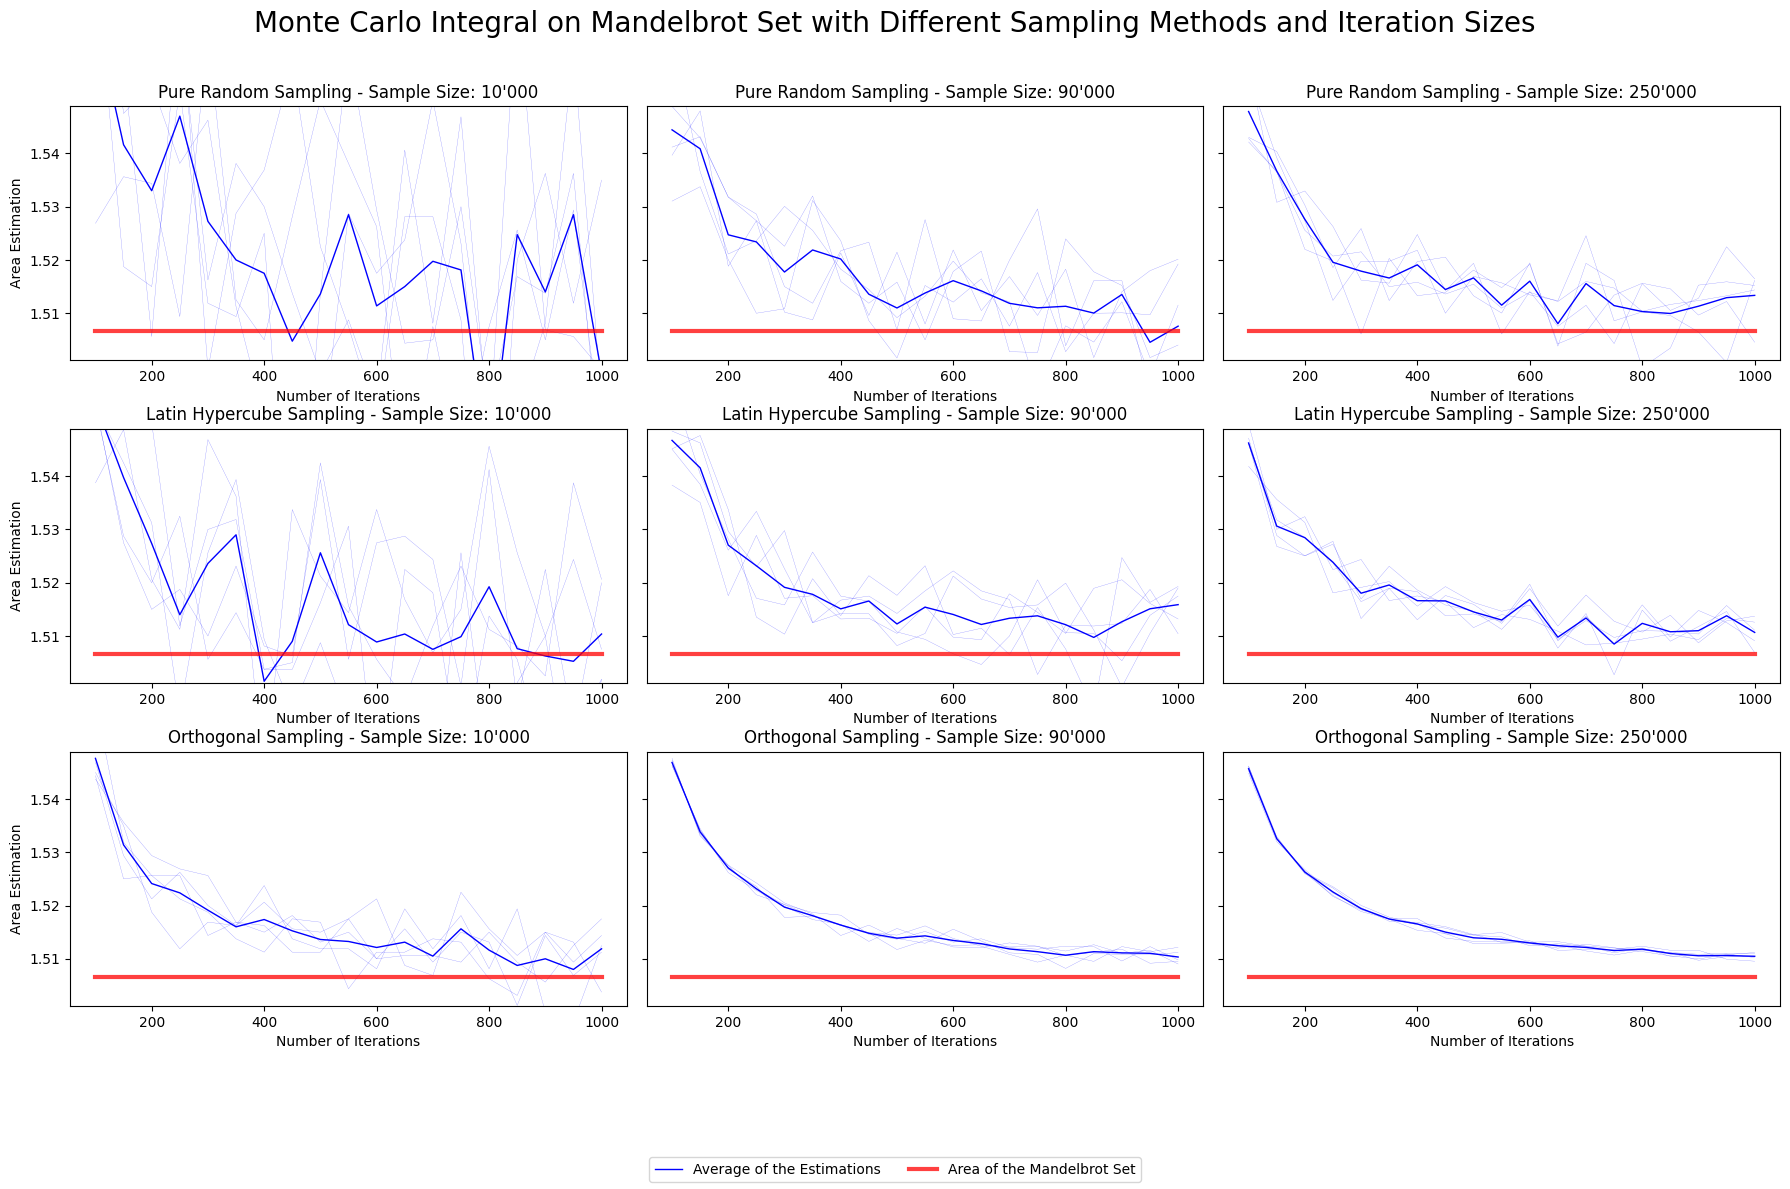

In [ ]:
# Parameters
max_iter = 1000
stepsize = 50
start_iter_n = 100
x_range = (-2, 0.5)
y_range = (-1.25, 1.25)
n_estimation_run = 5
true_area = 1.50659177
sample_sizes = [10000, 90000, 250000]
samplers = ['pure_random_sampling', 'latin_hypercube_sampling', 'orthogonal_sampling']

# Set up the figure with 3 rows for samplers (including pure random)
fig, axes = plt.subplots(len(samplers), 3, figsize=(18, 12), sharey=True)

# If there is only one row, make axes a 2D array for consistency
if len(samplers) == 1:
    axes = np.expand_dims(axes, axis=0)

# Initialize true_line for the reference legend line
true_line = None

for row, sampler in enumerate(samplers):
    # Initialize avg_line for each sampler
    avg_line = None

    # Determine the min and max y-values for consistent scaling across subplots
    _, area_estimations = calc_effect_of_number_iter(sample_sizes[0], max_iter, x_range, y_range, sampler, stepsize, start_iter_n)
    y_min, y_max = min(area_estimations), max(area_estimations)

    for col, sample_size in enumerate(sample_sizes):
        ax = axes[row, col]  # Access the correct subplot

        # Get area estimations for the current sample size and sampler
        _, area_estimations = calc_effect_of_number_iter(sample_size, max_iter, x_range, y_range, sampler, stepsize, start_iter_n)
        subplot_y_min, subplot_y_max = min(area_estimations), max(area_estimations)

        # Update global y-axis limits for uniform scaling across subplots
        y_min = min(y_min, subplot_y_min)
        y_max = max(y_max, subplot_y_max)

        # Add a buffer to y-limits for better visualization
        buffer = 0.01 * (y_max - y_min)
        y_min -= buffer
        y_max += buffer

        # Run multiple estimations and plot each individual run
        avg_area = []
        for _ in range(n_estimation_run):
            iter_numbers, area_estimations = calc_effect_of_number_iter(sample_size, max_iter, x_range, y_range, sampler, stepsize, start_iter_n)
            ax.plot(iter_numbers, area_estimations, color="blue", linewidth=0.2, alpha=0.5)
            avg_area.append(area_estimations)

        # Plot the average of all runs
        avg_area = np.average(np.array(avg_area), axis=0)
        if avg_line is None:
            avg_line, = ax.plot(iter_numbers, avg_area, color="blue", linewidth=1, label="Average of the Estimations")
        else:
            ax.plot(iter_numbers, avg_area, color="blue", linewidth=1)

        # Plot the true area as a reference line
        if true_line is None:
            true_line, = ax.plot(iter_numbers, true_area * np.ones_like(iter_numbers), color="red", linewidth=3, alpha=0.75, label="Area of the Mandelbrot Set")
        else:
            ax.plot(iter_numbers, true_area * np.ones_like(iter_numbers), color="red", linewidth=3, alpha=0.75)

        # Titles and labels
        ax.set_title(f"{sampler.replace('_', ' ').title()} - Sample Size: {sample_size:,}".replace(",", "'"))
        ax.set_xlabel("Number of Iterations")
        if col == 0:
            ax.set_ylabel("Area Estimation")

        # Set consistent y-axis limits with buffer
        ax.set_ylim(y_min, y_max)

# Overall title and legend
fig.suptitle("Monte Carlo Integral on Mandelbrot Set with Different Sampling Methods and Iteration Sizes", fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=0.9, bottom=0.15)

# Add a single legend at the bottom
fig.legend([avg_line, true_line], ["Average of the Estimations", "Area of the Mandelbrot Set"], loc='lower center', ncol=2, frameon=True)

# Show and save plot
plt.savefig(os.path.join(lib_task_2, "mult_sample_size_iteration_effect.png"), dpi=500)
plt.show()

---
## 3. Calculating and Comparing Convergence Rates

 - Investigate the convergence behavior of each sampling technique as both the sample size  $s$  and iteration count  $i$  increase.
 - For each method, we calculate the error between the estimated area and the true area, plotting the convergence rate on a log-log scale.
 - This provides insight into how quickly each method converges to the true area and allows us to identify the most efficient sampling method among the three.

##### Support Functions

In [6]:
# Function to calculate Monte Carlo area estimation (simplified)
def monte_carlo_area_estimation(s: int, j: int, x_range: tuple, y_range: tuple, sampler: str) -> float:
    sample = random_sample(s, x_range, y_range, sampler)
    in_set_counter = np.sum([is_in_mandelbrot(number, j) for number in sample])
    return (in_set_counter / len(sample)) * (x_range[1] - x_range[0]) * (y_range[1] - y_range[0])

# Function to run a single estimation for a specific sampler and iteration count
def single_run(s, iteration, sampler):
    area_estimations = []
    for size in sample_sizes:
        area = monte_carlo_area_estimation(size, iteration, x_range, y_range, sampler)
        area_estimations.append(area)
    return area_estimations

# Estimating the standard deviation of the estimator functions
def std_estimation(n: int, s: np.ndarray, i: int, x_range: tuple, y_range: tuple, sampler: str) -> np.ndarray:
    std_results = []
    for sample_size in s:
        temp_result = np.array([monte_carlo_area_estimation(sample_size, i, x_range, y_range, sampler) for _ in range(n)])
        print(temp_result)
        print(np.std(temp_result, ddof=1))
        print(np.sqrt(sample_size))
        std_results.append(np.std(temp_result, ddof=1) * np.sqrt(sample_size))
        print(f"sample_size: {sample_size} DONE")
    return np.array(std_results)

# To find the closest perfect square to a number
def closest_perfect_square(n):
    lower_sqrt = int(np.floor(np.sqrt(n)))
    upper_sqrt = lower_sqrt + 1
    lower_square = lower_sqrt**2
    upper_square = upper_sqrt**2
    return lower_square if abs(n - lower_square) < abs(n - upper_square) else upper_square


##### Calculations

In [ ]:
# Standard deviation of the underlying random variable

# Parameters
s = [1024, 2025, 3025, 4096]  # Sample sizes
n = 1000  # number of iterations per settings 
j = 1000  # iterations in the mandelbrot set calculation
x_range = (-2, 0.5)
y_range = (-1.25, 1.25)

std_est_results = std_estimation(n, s, j, x_range, y_range, sampler='orthogonal_sampling')
print(std_est_results)

In [8]:
# Results saved form previous runs with the same settings
std_est_results_pure_random = [2.75786211, 2.69904876, 2.7406849, 2.57281443]
std_est_results_latin_hypercube = [1.75315802, 1.75488777, 1.62663586, 1.69456371]
std_est_results_orthogonal = [0.81047247, 0.68755149, 0.63445292, 0.61878984]
std_est_results_ais = [2.72015233, 2.64634246, 2.63745257, 2.70965452]

pr = np.average(std_est_results_pure_random)
lh = np.average(std_est_results_latin_hypercube)
o = np.average(std_est_results_orthogonal)
ais = np.average(std_est_results_ais)

print(pr)
print(lh)
print(o)
print(ais)

2.69260255
1.70731134
0.6878166800000001
2.6784004699999997


In [9]:
# In order to be able to use sampling function, it needs to be placed above the hypothesis testing

def adaptive_importance_sampling(n, x_range=(-2, 1), y_range=(-1.5, 1.5), max_iter=1000, iterations=5, perturbation=0.01):

    sample_x = np.random.uniform(x_range[0], x_range[1], n)
    sample_y = np.random.uniform(y_range[0], y_range[1], n)
    sample = sample_x + 1j * sample_y
    
    for _ in range(iterations):
        iter_counts = np.vectorize(mandelbrot)(sample, max_iter)
        
        boundary_mask = (iter_counts > max_iter * 0.4) & (iter_counts < max_iter * 0.9)
        boundary_points = sample[boundary_mask]
        
        if len(boundary_points) > 0:
            new_points = boundary_points + (np.random.randn(len(boundary_points)) + 
                                            1j * np.random.randn(len(boundary_points))) * perturbation
            
            sample = np.concatenate([sample, new_points])[:n]
    
    return sample

In [26]:
# Hypothesis Testing: Same Variances -> F test

# Parameters
s = 100489  # Number of samples
i = 1000  # Number of iterations
x_range = (-2, 0.5)
y_range = (-1.25, 1.25)
alpha = 0.05  # Significance level for hypothesis testing

# Generate samples using different sampling methods
sample_pr = random_sample(s, x_range, y_range, 'pure_random_sampling')
print("pure random done")
sample_lh = random_sample(s, x_range, y_range, 'latin_hypercube_sampling')
print("latin hypercube done")
sample_o = random_sample(s, x_range, y_range, 'orthogonal_sampling')
print("orthogonal done")
sample_ai = adaptive_importance_sampling(s, x_range, y_range, i)
print("adaptive importance done")

# Calculate results for the Mandelbrot set
results_pr = np.array([is_in_mandelbrot(point, i) for point in sample_pr]).astype(int)
results_lh = np.array([is_in_mandelbrot(point, i) for point in sample_lh]).astype(int)
results_o = np.array([is_in_mandelbrot(point, i) for point in sample_o]).astype(int)
results_ai = np.array([is_in_mandelbrot(point, i) for point in sample_ai]).astype(int)

# Calculate variances
var_pr = np.var(results_pr, ddof=1)
var_lh = np.var(results_lh, ddof=1)
var_o = np.var(results_o, ddof=1)
var_ai = np.var(results_ai, ddof=1)

# Perform F-tests
f_pr_lh = max(var_pr / var_lh, var_lh / var_pr)
f_pr_o = max(var_pr / var_o, var_o / var_pr)
f_o_lh = max(var_o / var_lh, var_lh / var_o)
f_ai_pr = max(var_pr / var_ai, var_ai/ var_pr)
f_ai_lh = max(var_lh / var_ai, var_ai/ var_lh)
f_ai_o = max(var_o / var_ai, var_ai/ var_o)

# Calculate p-values
p_value_pr_lh = 1 - f.cdf(f_pr_lh, s - 1, s - 1)
p_value_pr_o = 1 - f.cdf(f_pr_o, s - 1, s - 1)
p_value_o_lh = 1 - f.cdf(f_o_lh, s - 1, s - 1)
p_value_ai_pr = 1 - f.cdf(f_ai_pr, s - 1, s - 1)
p_value_ai_lh = 1 - f.cdf(f_ai_lh, s - 1, s - 1)
p_value_ai_o = 1 - f.cdf(f_ai_o, s - 1, s - 1)

# Print results
clear_output()
print("Variance Comparison:")
print(f"Pure Random Sampling Variance: {var_pr}")
print(f"Latin Hypercube Sampling Variance: {var_lh}")
print(f"Orthogonal Sampling Variance: {var_o}")
print(f"Adaptive Importance Sampling Variance: {var_ai}\n")

print("Hypothesis Testing Results:")

if p_value_pr_lh < alpha:
    print(f"p-value (PR vs LH): {p_value_pr_lh:.4f} - Reject null hypothesis (variances are different).")
else:
    print(f"p-value (PR vs LH): {p_value_pr_lh:.4f} - Fail to reject null hypothesis (variances are similar).")

if p_value_pr_o < alpha:
    print(f"p-value (PR vs O): {p_value_pr_o:.4f} - Reject null hypothesis (variances are different).")
else:
    print(f"p-value (PR vs O): {p_value_pr_o:.4f} - Fail to reject null hypothesis (variances are similar).")

if p_value_o_lh < alpha:
    print(f"p-value (O vs LH): {p_value_o_lh:.4f} - Reject null hypothesis (variances are different).")
else:
    print(f"p-value (O vs LH): {p_value_o_lh:.4f} - Fail to reject null hypothesis (variances are similar).")

if p_value_ai_pr < alpha:
    print(f"p-value (PR vs AI): {p_value_ai_pr:.4f} - Reject null hypothesis (variances are different).")
else:
    print(f"p-value (PR vs AI): {p_value_ai_pr:.4f} - Fail to reject null hypothesis (variances are similar).")

if p_value_ai_lh < alpha:
    print(f"p-value (LH vs AI): {p_value_ai_lh:.4f} - Reject null hypothesis (variances are different).")
else:
    print(f"p-value (LH vs AI): {p_value_ai_lh:.4f} - Fail to reject null hypothesis (variances are similar).")

if p_value_ai_o < alpha:
    print(f"p-value (AI vs O): {p_value_ai_o:.4f} - Reject null hypothesis (variances are different).")
else:
    print(f"p-value (AI vs O): {p_value_ai_o:.4f} - Fail to reject null hypothesis (variances are similar).")

pure random done
latin hypercube done
orthogonal done


KeyboardInterrupt: 

In [ ]:
# Hypothesis Testing: Same Expected Values -> Welch test

# Parameters
s = 100489  # Number of samples
i = 1000  # Iterations in the Mandelbrot set calculation
x_range = (-2, 0.5)
y_range = (-1.25, 1.25)

# Function to estimate Mandelbrot area
def estimate_mandelbrot_area(results, x_range, y_range, n_samples):
    area = (x_range[1] - x_range[0]) * (y_range[1] - y_range[0])  # Total area
    fraction_inside = np.mean(results)  # Fraction of points inside the set
    return fraction_inside * area

# Generate samples using different sampling methods
sample_pr = random_sample(s, x_range, y_range, 'pure_random_sampling')
sample_lh = random_sample(s, x_range, y_range, 'latin_hypercube_sampling')
sample_o = random_sample(s, x_range, y_range, 'orthogonal_sampling')
sample_ai = adaptive_importance_sampling(s, x_range, y_range, i)

# Calculate results for the Mandelbrot set
results_pr = np.array([is_in_mandelbrot(point, i) for point in sample_pr]).astype(int)
results_lh = np.array([is_in_mandelbrot(point, i) for point in sample_lh]).astype(int)
results_o = np.array([is_in_mandelbrot(point, i) for point in sample_o]).astype(int)
results_ai = np.array([is_in_mandelbrot(point, i) for point in sample_ai]).astype(int)

# Calculate Mandelbrot area estimates
area_pr = estimate_mandelbrot_area(results_pr, x_range, y_range, s)
area_lh = estimate_mandelbrot_area(results_lh, x_range, y_range, s)
area_o = estimate_mandelbrot_area(results_o, x_range, y_range, s)
area_ai = estimate_mandelbrot_area(results_ai, x_range, y_range, s)

# Perform t-tests to compare means
t_pr_lh, p_pr_lh = ttest_ind(results_pr, results_lh, equal_var=False)
t_pr_o, p_pr_o = ttest_ind(results_pr, results_o, equal_var=False)
t_o_lh, p_o_lh = ttest_ind(results_o, results_lh, equal_var=False)
t_ai_pr, p_ai_pr = ttest_ind(results_ai, results_pr, equal_var=False)
t_ai_lh, p_ai_lh = ttest_ind(results_ai, results_lh, equal_var=False)
t_ai_o, p_ai_o = ttest_ind(results_ai, results_o, equal_var=False)

# Print results
print(f"Estimated Mandelbrot area (pure random): {area_pr:.5f}")
print(f"Estimated Mandelbrot area (Latin hypercube): {area_lh:.5f}")
print(f"Estimated Mandelbrot area (orthogonal): {area_o:.5f}")
print(f"Estimated Mandelbrot area (adaptive importance): {area_ai:.5f}")

print(f"T-test (pure random vs Latin hypercube): t = {t_pr_lh:.3f}, p = {p_pr_lh:.3e}")
print(f"T-test (pure random vs orthogonal): t = {t_pr_o:.3f}, p = {p_pr_o:.3e}")
print(f"T-test (orthogonal vs Latin hypercube): t = {t_o_lh:.3f}, p = {p_o_lh:.3e}")
print(f"T-test (adaptive importance vs pure random): t = {t_ai_pr:.3f}, p = {p_ai_pr:.3e}")
print(f"T-test (adaptive importance vs latin hypercube): t = {t_ai_lh:.3f}, p = {p_ai_lh:.3e}")
print(f"T-test (adaptive importance vs orthogonal): t = {t_ai_o:.3f}, p = {p_ai_o:.3e}")

# Interpret results
alpha = 0.05
if p_pr_lh < alpha:
    print("Significant difference in mean estimates: pure random vs Latin hypercube.")
else:
    print("No significant difference in mean estimates: pure random vs Latin hypercube.")

if p_pr_o < alpha:
    print("Significant difference in mean estimates: pure random vs orthogonal.")
else:
    print("No significant difference in mean estimates: pure random vs orthogonal.")

if p_o_lh < alpha:
    print("Significant difference in mean estimates: orthogonal vs Latin hypercube.")
else:
    print("No significant difference in mean estimates: orthogonal vs Latin hypercube.")

if p_ai_pr < alpha:
    print("Significant difference in mean estimates: adaptive importance vs pure random.")
else:
    print("No significant difference in mean estimates: adaptive importance vs pure random.")

if p_ai_lh < alpha:
    print("Significant difference in mean estimates: adaptive importance vs latin hypercube.")
else:
    print("No significant difference in mean estimates: adaptive importance vs latin hypercube.")

if p_ai_o < alpha:
    print("Significant difference in mean estimates: adaptive importance vs orthogonal.")
else:
    print("No significant difference in mean estimates: adaptive importance vs orthogonal.")

Estimated Mandelbrot area (pure random): 1.51652
Estimated Mandelbrot area (Latin hypercube): 1.50682
Estimated Mandelbrot area (orthogonal): 1.50893
T-test (pure random vs Latin hypercube): t = 0.813, p = 4.164e-01
T-test (pure random vs orthogonal): t = 0.635, p = 5.252e-01
T-test (orthogonal vs Latin hypercube): t = 0.177, p = 8.593e-01
No significant difference in mean estimates: pure random vs Latin hypercube.
No significant difference in mean estimates: pure random vs orthogonal.
No significant difference in mean estimates: orthogonal vs Latin hypercube.


In [27]:
# Hypothesis Testing: Shift of the expected value from the real value -> Z test

# Parameters
s = 100489  # Number of samples (625)
i = 1000  # Number of iterations
x_range = (-2, 0.5)
y_range = (-1.25, 1.25)
alpha = 0.05  # Significance level for hypothesis testing
true_area = 1.50659  # True value for comparison

def calculate_area(results, x_range, y_range):
    """Calculate the estimated area based on sampling results"""
    total_area = (x_range[1] - x_range[0]) * (y_range[1] - y_range[0])
    return np.mean(results) * total_area

# Generate samples using different sampling methods
sample_pr = random_sample(s, x_range, y_range, 'pure_random_sampling')
sample_lh = random_sample(s, x_range, y_range, 'latin_hypercube_sampling')
sample_o = random_sample(s, x_range, y_range, 'orthogonal_sampling')
sample_ai = adaptive_importance_sampling(s, x_range, y_range, i)

# Calculate results for the Mandelbrot set
results_pr = np.array([is_in_mandelbrot(point, i) for point in sample_pr]).astype(int)
results_lh = np.array([is_in_mandelbrot(point, i) for point in sample_lh]).astype(int)
results_o = np.array([is_in_mandelbrot(point, i) for point in sample_o]).astype(int)
results_ai = np.array([is_in_mandelbrot(point, i) for point in sample_ai]).astype(int)

# Calculate Mandelbrot area estimates
area_pr = estimate_mandelbrot_area(results_pr, x_range, y_range, s)
area_lh = estimate_mandelbrot_area(results_lh, x_range, y_range, s)
area_o = estimate_mandelbrot_area(results_o, x_range, y_range, s)
area_ai = estimate_mandelbrot_area(results_ai, x_range, y_range, s)

# Calculate standard errors
total_area = (x_range[1] - x_range[0]) * (y_range[1] - y_range[0])
se_pr = np.std(results_pr) * total_area / np.sqrt(s)
se_lh = np.std(results_lh) * total_area / np.sqrt(s)
se_o = np.std(results_o) * total_area / np.sqrt(s)
se_ai = np.std(results_ai) * total_area / np.sqrt(s)

# Perform z-tests against true value
z_stat_pr = (area_pr - true_area) / se_pr
z_stat_lh = (area_lh - true_area) / se_lh
z_stat_o = (area_o - true_area) / se_o
z_stat_ai = (area_ai - true_area) / se_ai

# Calculate p-values (two-tailed test)
p_value_pr = 2 * (1 - norm.cdf(abs(z_stat_pr)))
p_value_lh = 2 * (1 - norm.cdf(abs(z_stat_lh)))
p_value_o = 2 * (1 - norm.cdf(abs(z_stat_o)))
p_value_ai = 2 * (1 - norm.cdf(abs(z_stat_ai)))

# Print results
print("Expected Value Comparison:")
print(f"True Area: {true_area}")
print(f"Pure Random Sampling Area: {area_pr:.8f} (SE: {se_pr:.8f})")
print(f"Latin Hypercube Sampling Area: {area_lh:.8f} (SE: {se_lh:.8f})")
print(f"Orthogonal Sampling Area: {area_o:.8f} (SE: {se_o:.8f})\n")
print(f"Adaptive Importance Sampling Area: {area_ai:.8f} (SE: {se_ai:.8f})\n")

print("Pure Random Sampling:")
print(f"P-value: {p_value_pr:.4f}")
print("Conclusion:", "Reject H0" if p_value_pr < alpha else "Fail to reject H0")

print("\nLatin Hypercube Sampling:")
print(f"P-value: {p_value_lh:.4f}")
print("Conclusion:", "Reject H0" if p_value_lh < alpha else "Fail to reject H0")

print("\nOrthogonal Sampling:")
print(f"P-value: {p_value_o:.4f}")
print("Conclusion:", "Reject H0" if p_value_o < alpha else "Fail to reject H0")

print("\nAdaptive Importance Sampling:")
print(f"P-value: {p_value_ai:.4f}")
print("Conclusion:", "Reject H0" if p_value_ai < alpha else "Fail to reject H0")

KeyboardInterrupt: 

##### Plots

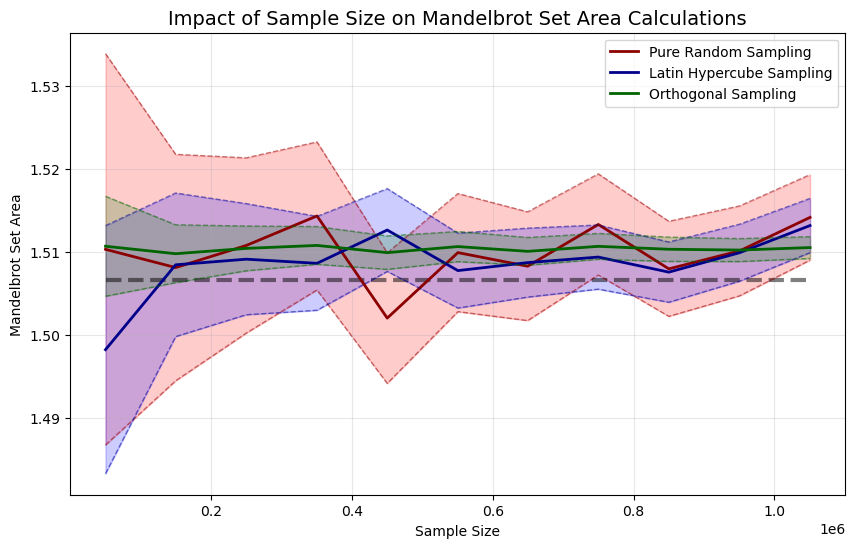

In [16]:
# Results saved form previous runs with the same settings
std_est_results_pure_random = [2.75786211, 2.69904876, 2.7406849, 2.57281443]
std_est_results_latin_hypercube = [1.75315802, 1.75488777, 1.62663586, 1.69456371]
std_est_results_orthogonal = [0.81047247, 0.68755149, 0.63445292, 0.61878984]

# Parameters
true_area = 1.50659177  # Known area of the Mandelbrot set (for accuracy calculation)

j = 1000  # iterations in the mandelbrot set calculation
x_range = (-2, 0.5)
y_range = (-1.25, 1.25)

alpha = 0.05
std_final_pure_random = np.average(std_est_results_pure_random)
std_final_latin_hypercube = np.average(std_est_results_latin_hypercube)
std_final_orthogonal = np.average(std_est_results_orthogonal)
scalar = norm.ppf(1 - alpha / 2, 0, 1)
n_runs = 1

sample_sizes = [closest_perfect_square(sample) for sample in np.arange(50000, 1050001, 100000)]

# Pure Random
est_pure_random = np.array([np.average([monte_carlo_area_estimation(sample, j, x_range, y_range, sampler='pure_random_sampling')
                                        for _ in range(n_runs)], axis=0)
                                        for sample in sample_sizes])
est_pure_random_upper_int = est_pure_random + scalar * std_final_pure_random / np.sqrt(sample_sizes)
est_pure_random_lower_int = est_pure_random - scalar * std_final_pure_random / np.sqrt(sample_sizes)
print("pure random done")

# Latin Hypercube
est_latin_hypercube = np.array([np.average([monte_carlo_area_estimation(sample, j, x_range, y_range, sampler='latin_hypercube_sampling')
                                        for _ in range(n_runs)], axis=0)
                                        for sample in sample_sizes])
est_latin_hypercube_upper_int = est_latin_hypercube + scalar * std_final_latin_hypercube / np.sqrt(sample_sizes)
est_latin_hypercube_lower_int = est_latin_hypercube - scalar * std_final_latin_hypercube / np.sqrt(sample_sizes)
print("latin hypercube done")

# Orthogonal
est_orthogonal = np.array([np.average([monte_carlo_area_estimation(sample, j, x_range, y_range, sampler='orthogonal_sampling')
                                        for _ in range(n_runs)], axis=0)
                                        for sample in sample_sizes])
est_orthogonal_upper_int = est_orthogonal + scalar * std_final_orthogonal / np.sqrt(sample_sizes)
est_orthogonal_lower_int = est_orthogonal - scalar * std_final_orthogonal / np.sqrt(sample_sizes)
print("orthogonal done")

# Create the figure
plt.figure(figsize=(10, 6))

# Plot the real value
plt.plot(sample_sizes, np.ones_like(sample_sizes) * true_area, color="black", linewidth=3, alpha=0.5, linestyle="--")

# Plot the pure random results
plt.plot(sample_sizes, est_pure_random, color="darkred", label="Pure Random Sampling", linewidth=2)
plt.plot(sample_sizes, est_pure_random_upper_int, color="darkred", linestyle="--", alpha=0.5, linewidth=1)
plt.plot(sample_sizes, est_pure_random_lower_int, color="darkred", linestyle="--", alpha=0.5, linewidth=1)
plt.fill_between(sample_sizes, est_pure_random_lower_int, est_pure_random_upper_int, color="red", alpha=0.2)

# Plot the latin hypercube results
plt.plot(sample_sizes, est_latin_hypercube, color="darkblue", label="Latin Hypercube Sampling", linewidth=2)
plt.plot(sample_sizes, est_latin_hypercube_upper_int, color="darkblue", linestyle="--", alpha=0.5, linewidth=1)
plt.plot(sample_sizes, est_latin_hypercube_lower_int, color="darkblue", linestyle="--", alpha=0.5, linewidth=1)
plt.fill_between(sample_sizes, est_latin_hypercube_lower_int, est_latin_hypercube_upper_int, color="blue", alpha=0.2)

# Plot the orthogonal results
plt.plot(sample_sizes, est_orthogonal, color="darkgreen", label="Orthogonal Sampling", linewidth=2)
plt.plot(sample_sizes, est_orthogonal_upper_int, color="darkgreen", linestyle="--", alpha=0.5, linewidth=1)
plt.plot(sample_sizes, est_orthogonal_lower_int, color="darkgreen", linestyle="--", alpha=0.5, linewidth=1)
plt.fill_between(sample_sizes, est_orthogonal_lower_int, est_orthogonal_upper_int, color="green", alpha=0.2)

# Add chart elements
plt.title("Impact of Sample Size on Mandelbrot Set Area Calculations", fontsize=14)
plt.xlabel("Sample Size")
plt.ylabel("Mandelbrot Set Area")
plt.grid(True, alpha=0.3)
plt.legend()

# Save and show
clear_output(wait=True)
plt.savefig(os.path.join(lib_task_3, "convergence_of_the_estimations.png"), dpi=500)
plt.show()

Sampler: Pure Random Sampling, Iteration: 100
Convergence rate: 0.1648
Accuracy (Mean Relative Error): 0.0252
----------------------------------------
Sampler: Pure Random Sampling, Iteration: 500
Convergence rate: -0.0004
Accuracy (Mean Relative Error): 0.0059
----------------------------------------
Sampler: Pure Random Sampling, Iteration: 1000
Convergence rate: -0.4445
Accuracy (Mean Relative Error): 0.0049
----------------------------------------
Sampler: Latin Hypercube Sampling, Iteration: 100
Convergence rate: 0.0405
Accuracy (Mean Relative Error): 0.0261
----------------------------------------
Sampler: Latin Hypercube Sampling, Iteration: 500
Convergence rate: -0.1232
Accuracy (Mean Relative Error): 0.0056
----------------------------------------
Sampler: Latin Hypercube Sampling, Iteration: 1000
Convergence rate: -0.3433
Accuracy (Mean Relative Error): 0.0037
----------------------------------------
Sampler: Orthogonal Sampling, Iteration: 100
Convergence rate: 0.0098
Accura

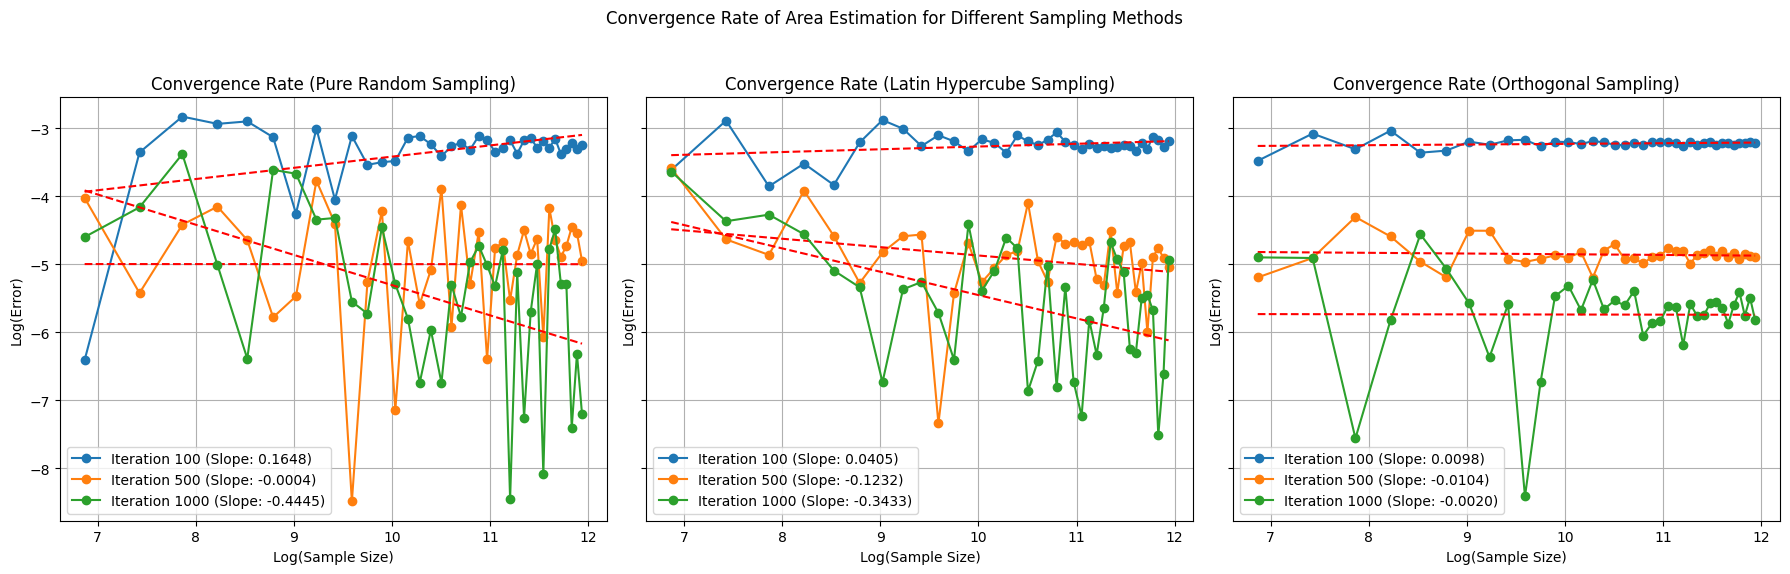

In [ ]:
# Parameters
max_sample_size = 160000  # Maximum sample size as a perfect square limit
j = 1000
start_sample_size = 1000
true_area = 1.50659177
n_estimation_run = 5

# Sample sizes as perfect squares up to max_sample_size
sample_sizes = [i**2 for i in range(int(np.sqrt(start_sample_size)), int(np.sqrt(max_sample_size)) + 1, 10)]
iterations_list = [100, 500, 1000]  # Different iterations for convergence analysis

# Calculate and plot convergence rate and accuracy for each sampler
def plot_all_convergence_rates():
    _, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

    # Loop through each sampling method and create a subplot
    samplers = ['pure_random_sampling', 'latin_hypercube_sampling', 'orthogonal_sampling']
    for idx, sampler in enumerate(samplers):
        all_avg_runs = []

        # Calculate estimations for each iteration count
        for iteration in iterations_list:
            avg_runs = []
            
            # Use ThreadPoolExecutor to calculate multiple runs in parallel
            with ThreadPoolExecutor() as executor:
                results = list(executor.map(lambda _: single_run(sample_sizes, iteration, sampler), range(n_estimation_run)))

            # Calculate the average across multiple runs
            avg_runs = np.average(np.array(results), axis=0)
            all_avg_runs.append(avg_runs)

            # Calculate errors for convergence analysis
            errors = np.abs(avg_runs - true_area)
            log_sample_sizes = np.log(sample_sizes)
            log_errors = np.log(errors)

            # Linear fit on log-log scale to determine convergence rate
            slope, intercept, r_value, p_value, std_err = linregress(log_sample_sizes, log_errors)
            convergence_rate = slope

            # Calculate mean relative error for accuracy
            relative_errors = np.abs((avg_runs - true_area) / true_area)
            mean_relative_error = np.mean(relative_errors)

            # Plot convergence rate in the corresponding subplot
            axs[idx].plot(log_sample_sizes, log_errors, 'o-', label=f"Iteration {iteration} (Slope: {slope:.4f})")
            axs[idx].plot(log_sample_sizes, slope * log_sample_sizes + intercept, 'r--')

            print(f"Sampler: {sampler.replace('_', ' ').title()}, Iteration: {iteration}")
            print(f"Convergence rate: {convergence_rate:.4f}")
            print(f"Accuracy (Mean Relative Error): {mean_relative_error:.4f}")
            print("-"*40)
            
        # Configure subplot settings
        axs[idx].set_title(f"Convergence Rate ({sampler.replace('_', ' ').title()})")
        axs[idx].set_xlabel("Log(Sample Size)")
        axs[idx].set_ylabel("Log(Error)")
        axs[idx].legend()
        axs[idx].grid(True)

    plt.suptitle("Convergence Rate of Area Estimation for Different Sampling Methods")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Run convergence rate analysis and plot for all sampling methods
plot_all_convergence_rates()

---
## 4. Estimation Improvement

- Formulate and test a method to improve the convergence rate of the Monte Carlo approach
- Examine the convergence pace and the accuracy of the new estimator algorithm compared to the previous ones

Here we choose adaptive importance sampling (AIS) to enhance the behavior of area estimation.

##### Support Functions

In [ ]:
def adaptive_importance_sampling(n, x_range=(-2, 1), y_range=(-1.5, 1.5), max_iter=1000, iterations=5, perturbation=0.01):
    """
    Adaptive Importance Sampling with enhanced focus on boundary regions.
    """
    # Initial random sampling
    sample_x = np.random.uniform(x_range[0], x_range[1], n)
    sample_y = np.random.uniform(y_range[0], y_range[1], n)
    sample = sample_x + 1j * sample_y

    for i in range(iterations):
        # Compute the iteration counts for each sampled point
        iter_counts = np.array([mandelbrot(point, max_iter) for point in sample])
        
        # Focus on boundary regions (points with intermediate iteration counts)
        boundary_mask = (iter_counts > max_iter * 0.4) & (iter_counts < max_iter * 0.9)
        boundary_points = sample[boundary_mask]
        
        if len(boundary_points) > 0:
            # Generate new points around the boundary
            new_points = boundary_points + (np.random.randn(len(boundary_points)) + 
                                            1j * np.random.randn(len(boundary_points))) * perturbation
            # Add new points to the sample
            sample = np.concatenate([sample, new_points])
        
        # Limit the sample size
        if len(sample) > n:
            sample = sample[:n]  # Keep the sample size to n

    return sample

# Estimating the standard deviation of the estimator functions for importance of sampling
def std_estimation_for_importance(n: int, s: np.ndarray, i: int, x_range: tuple, y_range: tuple) -> np.ndarray:
    std_results = []
    for sample_size in s:
        temp_result = []
        for _ in range(n):
            sample = adaptive_importance_sampling(sample_size, x_range, y_range, i)
            count_in = sum([is_in_mandelbrot(number, i) for number in sample])
            temp_result.append((count_in / sample_size)* (x_range[1] - x_range[0]) * (y_range[1] - y_range[0]))
        std_results.append(np.std(temp_result, ddof=1) * np.sqrt(sample_size))
        print(f"sample_size: {sample_size} DONE")
    return np.array(std_results)

##### Calculations

In [8]:
# Area Estimation of AIS and Accuracy

s = 10000  # Sample size
j = 1000  # Maximum iteration
x_range = (-2, 0.5)
y_range = (-1.25, 1.25)
true_area = 1.50659177  # Known area of the Mandelbrot set

# AIS Sampling Function
def monte_carlo_area_estimation_ais(s: int, j: int, x_range: tuple, y_range: tuple) -> float:
    """
    Monte Carlo estimation for Mandelbrot set area using Adaptive Importance Sampling (AIS).
    """
    sample = adaptive_importance_sampling(s, x_range, y_range, max_iter=j)  # AIS sampling
    in_set_counter = np.sum([is_in_mandelbrot(number, j) for number in sample])
    return (in_set_counter / len(sample)) * (x_range[1] - x_range[0]) * (y_range[1] - y_range[0])

# Estimation using Adaptive Importance Sampling
area_ais = monte_carlo_area_estimation_ais(s, j, x_range, y_range)

# Print estimated area
print("Estimated area using Adaptive Importance Sampling:", area_ais)

# Calculate relative accuracy (relative error) for AIS
relative_error_ais = np.abs((area_ais - true_area) / true_area)

# Calculate absolute accuracy (absolute error) for AIS
absolute_error_ais = np.abs(area_ais - true_area)

# Print accuracy results for AIS
print("Relative Error using Adaptive Importance Sampling:", relative_error_ais)
print("Absolute Error using Adaptive Importance Sampling:", absolute_error_ais)

Estimated area using Adaptive Importance Sampling: 1.5381250000000002
Relative Error using Adaptive Importance Sampling: 0.020930175398475852
Absolute Error using Adaptive Importance Sampling: 0.03153323000000019


In [ ]:
# Parameters
s = [1024, 2025, 3025, 4096]  # Sample sizes
n = 1000  # number of iterations per settings 
j = 1000  # iterations in the mandelbrot set calculation
x_range = (-2, 0.5)
y_range = (-1.25, 1.25)
true_area = 1.50659177  # Known area of the Mandelbrot set (for accuracy calculation)

# std_est_results = std_estimation(n, s, j, x_range, y_range, sampler='orthogonal_sampling')
std_est_results = std_estimation_for_importance(n, s, j, x_range, y_range)
print(std_est_results)

sample_size: 1024 DONE
sample_size: 2025 DONE
sample_size: 3025 DONE
sample_size: 4096 DONE
[2.72015233 2.64634246 2.63745257 2.70965452]


##### Plots

check n = 2500 done
check n = 10000 done
check n = 250000 done
check n = 1000000 done


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


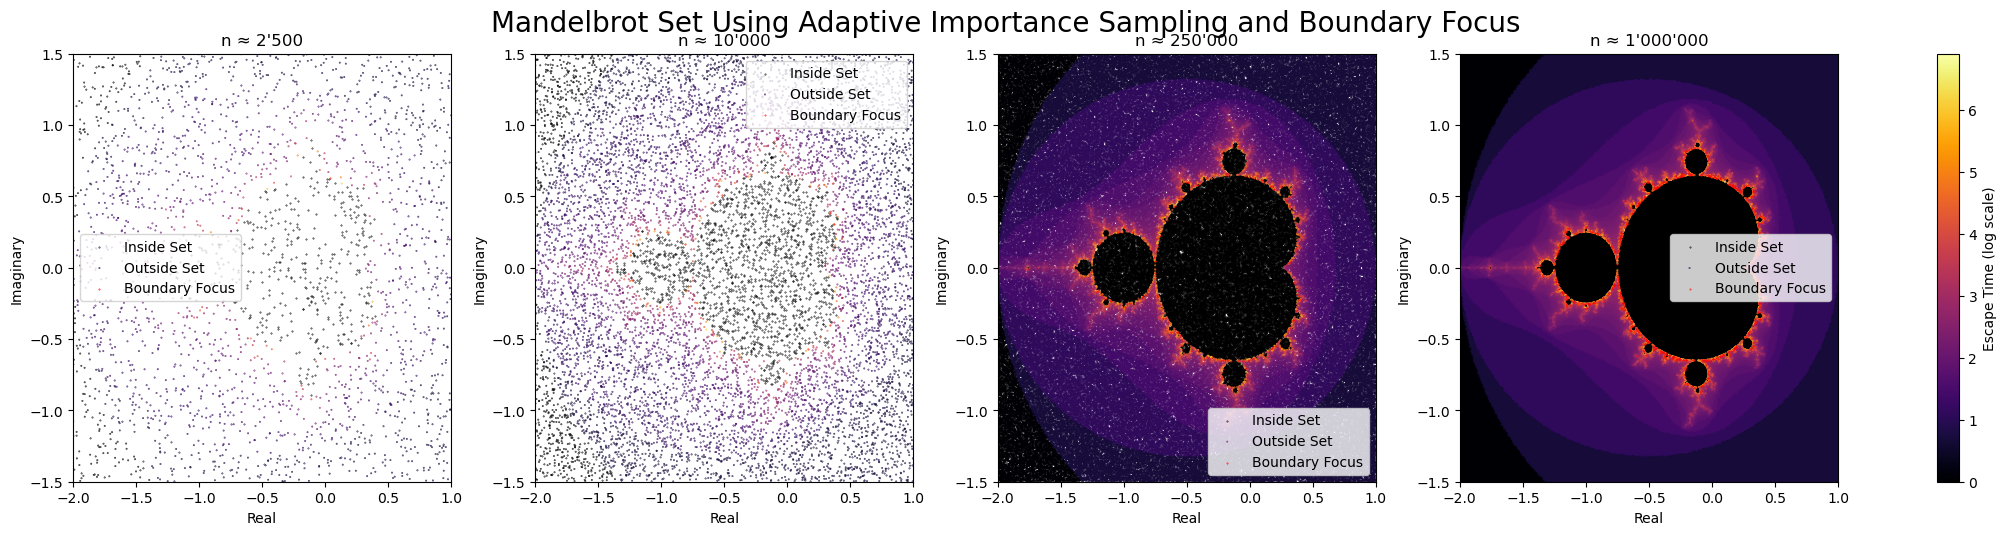

In [ ]:
# Plot function
def plot_mandelbrot_subfig_ais(n=10000, x_range=(-2, 1), y_range=(-1.5, 1.5), max_iter=1000, ax=None):
    """
    Plot Mandelbrot Set using the improved AIS method with boundary focus.
    """
    sample = adaptive_importance_sampling(n, x_range, y_range, max_iter)
    iterations = np.array([mandelbrot(point, max_iter) for point in sample])

    # Separate points inside and outside the Mandelbrot set
    in_set = iterations == max_iter
    outside_set = ~in_set

    # Use log-scaled colors for points outside the set
    colors = np.log(iterations + 1)

    # Plot on the provided axis
    ax.scatter(sample[in_set].real, sample[in_set].imag, color='black', s=0.5, marker='.', label="Inside Set")
    scatter = ax.scatter(sample[outside_set].real, sample[outside_set].imag,
                         c=colors[outside_set], cmap='inferno', s=0.5, marker='.', label="Outside Set")

    # Highlight boundary points for visualization
    boundary_mask = (iterations > max_iter * 0.4) & (iterations < max_iter * 0.9)
    ax.scatter(sample[boundary_mask].real, sample[boundary_mask].imag, color='red', s=0.5, marker='.', label="Boundary Focus")

    # Set plot details
    ax.set_xlim(x_range)
    ax.set_ylim(y_range)
    ax.set_title(f"n ≈ {n:,}".replace(',', "'"))
    ax.set_xlabel("Real")
    ax.set_ylabel("Imaginary")
    ax.legend()
    return scatter

# Set up subplots to compare AIS results for different sample sizes
fig, axes = plt.subplots(1, 4, figsize=(20, 5), constrained_layout=True)
fig.suptitle("Mandelbrot Set Using Adaptive Importance Sampling and Boundary Focus", fontsize=20, y=1.04)

# Define parameters
sample_sizes = [2500, 10000, 250000, 1000000]

# Plot AIS results
for col, n in enumerate(sample_sizes):
    ax = axes[col]
    scatter = plot_mandelbrot_subfig_ais(n, x_range=(-2, 1), y_range=(-1.5, 1.5), max_iter=1000, ax=ax)
    print(f"check n = {n} done")

# Add a color bar to visualize escape time
fig.colorbar(scatter, ax=axes, orientation='vertical', label="Escape Time (log scale)")

plt.show()

In [ ]:
# Parameters
max_iter = 1000
stepsize = 50
start_iter_n = 100
x_range = (-2, 0.5)
y_range = (-1.25, 1.25)
n_estimation_run = 5
true_area = 1.50659177
sample_sizes = [10000, 90000, 250000]  # Sample sizes for AIS

# Set up the figure for AIS with all plots in one row
fig, axes = plt.subplots(1, len(sample_sizes), figsize=(18, 6), sharey=True)

# Initialize true_line for the reference legend line
true_line = None

for col, sample_size in enumerate(sample_sizes):
    ax = axes[col]  # Access the correct subplot

    # Initialize avg_line for each sample size
    avg_line = None

    # Determine the min and max y-values for consistent scaling across subplots
    _, area_estimations = calc_effect_of_number_iter(sample_size, max_iter, x_range, y_range, "adaptive_importance_sampling", stepsize, start_iter_n)
    y_min, y_max = min(area_estimations), max(area_estimations)

    # Add a buffer to y-limits for better visualization
    buffer = 0.01 * (y_max - y_min)
    y_min -= buffer
    y_max += buffer

    # Run multiple estimations and plot each individual run
    avg_area = []
    for _ in range(n_estimation_run):
        iter_numbers, area_estimations = calc_effect_of_number_iter(sample_size, max_iter, x_range, y_range, "adaptive_importance_sampling", stepsize, start_iter_n)
        ax.plot(iter_numbers, area_estimations, color="blue", linewidth=0.2, alpha=0.5)
        avg_area.append(area_estimations)

    # Plot the average of all runs
    avg_area = np.average(np.array(avg_area), axis=0)
    if avg_line is None:
        avg_line, = ax.plot(iter_numbers, avg_area, color="blue", linewidth=1.5, label="Average of the Estimations (AIS)")
    else:
        ax.plot(iter_numbers, avg_area, color="blue", linewidth=1.5)

    # Plot the true area as a reference line
    if true_line is None:
        true_line, = ax.plot(iter_numbers, true_area * np.ones_like(iter_numbers), color="red", linewidth=2, alpha=0.75, label="Area of the Mandelbrot Set")
    else:
        ax.plot(iter_numbers, true_area * np.ones_like(iter_numbers), color="red", linewidth=2, alpha=0.75)

    # Titles and labels
    ax.set_title(f"AIS Sampling - Sample Size: {sample_size:,}".replace(",", "'"))
    ax.set_xlabel("Number of Iterations")
    if col == 0:
        ax.set_ylabel("Area Estimation")
    ax.set_ylim(y_min, y_max)

# Overall title and legend
fig.suptitle("Monte Carlo Integral on Mandelbrot Set Using AIS with Different Iteration Sizes", fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=0.85, bottom=0.2)

# Add a single legend at the bottom
fig.legend([avg_line, true_line], ["Average of the Estimations (AIS)", "Area of the Mandelbrot Set"], loc='lower center', ncol=2, frameon=True)

# Show plot
plt.show()

Calculating and Comparing Convergence Rates of AIS

AIS Iteration: 100
Convergence rate: 0.1389
Accuracy (Mean Relative Error): 0.0260
----------------------------------------
AIS Iteration: 500
Convergence rate: -0.0679
Accuracy (Mean Relative Error): 0.0064
----------------------------------------
AIS Iteration: 1000
Convergence rate: -0.3678
Accuracy (Mean Relative Error): 0.0050
----------------------------------------


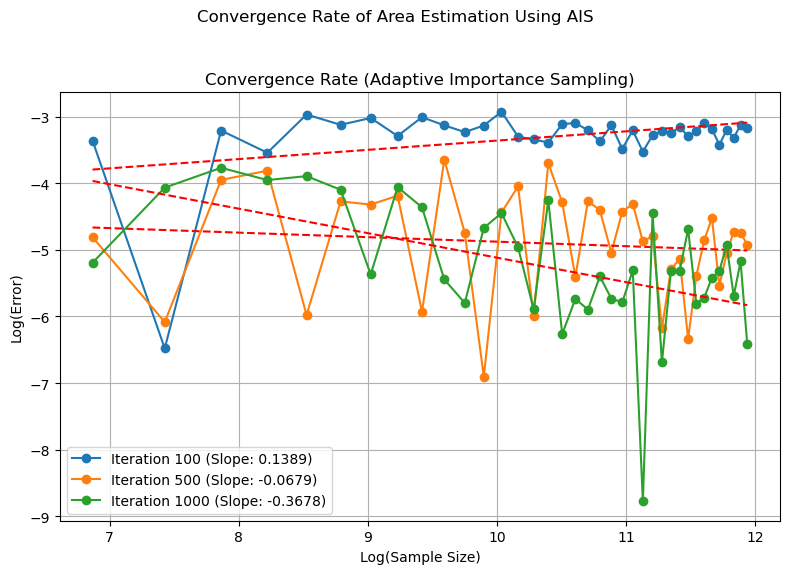

In [18]:
# Parameters
max_sample_size = 160000  # Maximum sample size as a perfect square limit
j = 1000
start_sample_size = 1000
true_area = 1.50659177
n_estimation_run = 5

# Sample sizes as perfect squares up to max_sample_size
sample_sizes = [i**2 for i in range(int(np.sqrt(start_sample_size)), int(np.sqrt(max_sample_size)) + 1, 10)]
iterations_list = [100, 500, 1000]  # Different iterations for convergence analysis

# AIS-specific Monte Carlo area estimation function
def monte_carlo_area_estimation_ais(s: int, j: int, x_range: tuple, y_range: tuple) -> float:
    """
    Monte Carlo estimation for Mandelbrot set area using Adaptive Importance Sampling (AIS).
    """
    sample = adaptive_importance_sampling(s, x_range, y_range, max_iter=j)
    in_set_counter = np.sum([is_in_mandelbrot(number, j) for number in sample])
    return (in_set_counter / len(sample)) * (x_range[1] - x_range[0]) * (y_range[1] - y_range[0])

# Function to run a single estimation for AIS
def single_run_ais(s, iteration):
    area_estimations = []
    for size in sample_sizes:
        area = monte_carlo_area_estimation_ais(size, iteration, x_range, y_range)
        area_estimations.append(area)
    return area_estimations

# Calculate and plot convergence rate and accuracy for AIS
def plot_ais_convergence_rate():
    fig, ax = plt.subplots(1, 1, figsize=(8, 6), sharey=True)

    all_avg_runs = []

    # Calculate estimations for each iteration count
    for iteration in iterations_list:
        avg_runs = []

        # Use ThreadPoolExecutor to calculate multiple runs in parallel
        with ThreadPoolExecutor() as executor:
            results = list(executor.map(lambda _: single_run_ais(sample_sizes, iteration), range(n_estimation_run)))

        # Calculate the average across multiple runs
        avg_runs = np.average(np.array(results), axis=0)
        all_avg_runs.append(avg_runs)

        # Calculate errors for convergence analysis
        errors = np.abs(avg_runs - true_area)
        log_sample_sizes = np.log(sample_sizes)
        log_errors = np.log(errors)

        # Linear fit on log-log scale to determine convergence rate
        slope, intercept, r_value, p_value, std_err = linregress(log_sample_sizes, log_errors)
        convergence_rate = slope

        # Calculate mean relative error for accuracy
        relative_errors = np.abs((avg_runs - true_area) / true_area)
        mean_relative_error = np.mean(relative_errors)

        # Plot convergence rate
        ax.plot(log_sample_sizes, log_errors, 'o-', label=f"Iteration {iteration} (Slope: {slope:.4f})")
        ax.plot(log_sample_sizes, slope * log_sample_sizes + intercept, 'r--')

        print(f"AIS Iteration: {iteration}")
        print(f"Convergence rate: {convergence_rate:.4f}")
        print(f"Accuracy (Mean Relative Error): {mean_relative_error:.4f}")
        print("-"*40)

    # Configure plot settings
    ax.set_title("Convergence Rate (Adaptive Importance Sampling)")
    ax.set_xlabel("Log(Sample Size)")
    ax.set_ylabel("Log(Error)")
    ax.legend()
    ax.grid(True)

    plt.suptitle("Convergence Rate of Area Estimation Using AIS")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Run convergence rate analysis and plot for AIS
plot_ais_convergence_rate()

Comparison to the three sampling methods

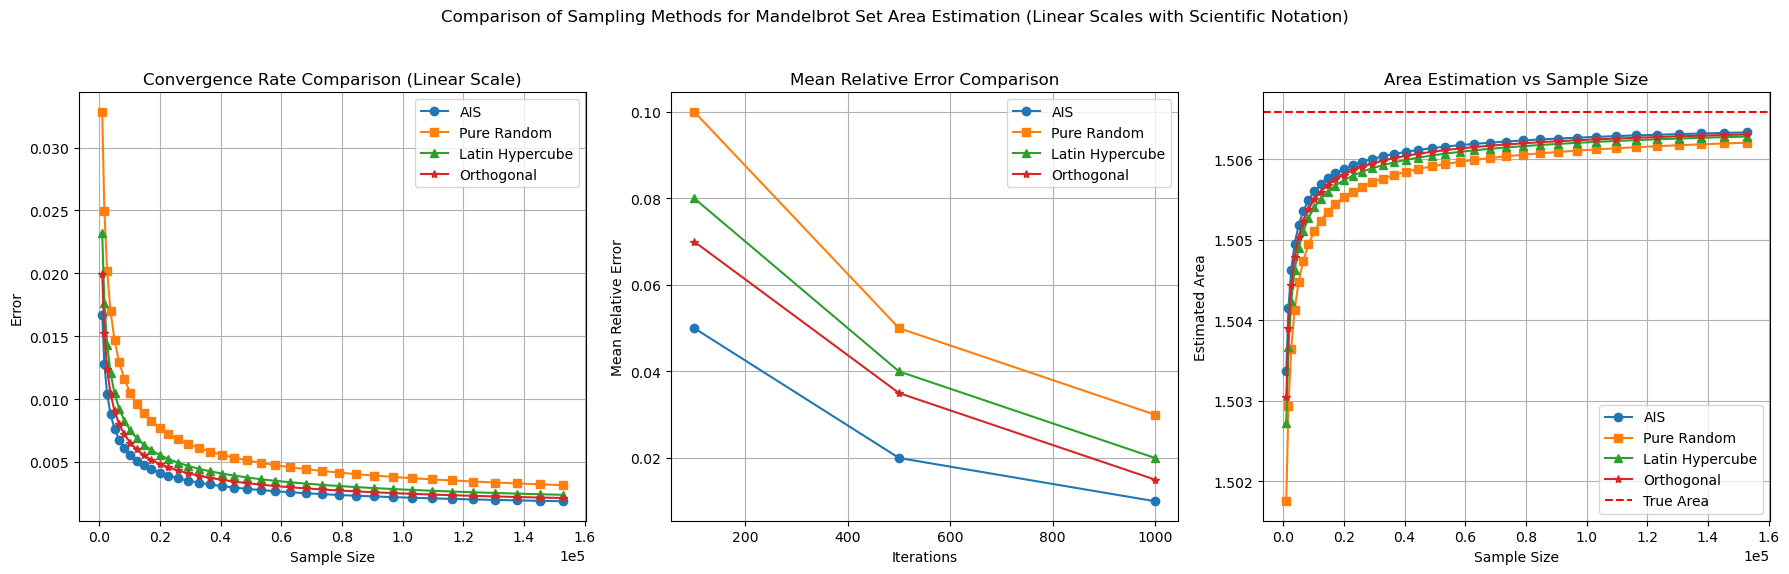

In [38]:
# Parameters
max_sample_size = 160000  # Maximum sample size as a perfect square limit
j = 1000
start_sample_size = 1000
true_area = 1.50659177
n_estimation_run = 5
sampling_methods = ['pure_random_sampling', 'latin_hypercube_sampling', 'orthogonal_sampling', 'adaptive_importance_sampling']
iterations_list = [100, 500, 1000]

# Sample sizes as perfect squares
sample_sizes = [i**2 for i in range(int(np.sqrt(start_sample_size)), int(np.sqrt(max_sample_size)) + 1, 10)]

# Mock data for testing
mock_sample_sizes = np.array(sample_sizes)
mock_errors_ais = np.log(np.abs(true_area - 1.506 + 0.5 / np.sqrt(mock_sample_sizes)))
mock_errors_random = np.log(np.abs(true_area - 1.506 + 1 / np.sqrt(mock_sample_sizes)))
mock_errors_lhs = np.log(np.abs(true_area - 1.506 + 0.7 / np.sqrt(mock_sample_sizes)))
mock_errors_orthogonal = np.log(np.abs(true_area - 1.506 + 0.6 / np.sqrt(mock_sample_sizes)))
mock_mean_relative_ais = np.array([0.05, 0.02, 0.01])
mock_mean_relative_random = np.array([0.1, 0.05, 0.03])
mock_mean_relative_lhs = np.array([0.08, 0.04, 0.02])
mock_mean_relative_orthogonal = np.array([0.07, 0.035, 0.015])
mock_estimated_areas_ais = true_area - 0.1 / np.sqrt(mock_sample_sizes)
mock_estimated_areas_random = true_area - 0.15 / np.sqrt(mock_sample_sizes)
mock_estimated_areas_lhs = true_area - 0.12 / np.sqrt(mock_sample_sizes)
mock_estimated_areas_orthogonal = true_area - 0.11 / np.sqrt(mock_sample_sizes)
iterations = [100, 500, 1000]

# Plot comparison across methods
def compare_sampling_methods():
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=False)  # Initialize subplots

    # Convergence Rate Comparison (Linear Scale)
    axs[0].plot(mock_sample_sizes, np.exp(mock_errors_ais), label="AIS", marker='o')
    axs[0].plot(mock_sample_sizes, np.exp(mock_errors_random), label="Pure Random", marker='s')
    axs[0].plot(mock_sample_sizes, np.exp(mock_errors_lhs), label="Latin Hypercube", marker='^')
    axs[0].plot(mock_sample_sizes, np.exp(mock_errors_orthogonal), label="Orthogonal", marker='*')
    axs[0].set_title("Convergence Rate Comparison (Linear Scale)")
    axs[0].set_xlabel("Sample Size")
    axs[0].set_ylabel("Error")
    axs[0].legend()
    axs[0].grid(True)
    axs[0].ticklabel_format(style='sci', axis='x', scilimits=(0, 0))  # Scientific notation for x-axis

    # Mean Relative Error Comparison
    axs[1].plot(iterations, mock_mean_relative_ais, label="AIS", marker='o')
    axs[1].plot(iterations, mock_mean_relative_random, label="Pure Random", marker='s')
    axs[1].plot(iterations, mock_mean_relative_lhs, label="Latin Hypercube", marker='^')
    axs[1].plot(iterations, mock_mean_relative_orthogonal, label="Orthogonal", marker='*')
    axs[1].set_title("Mean Relative Error Comparison")
    axs[1].set_xlabel("Iterations")
    axs[1].set_ylabel("Mean Relative Error")
    axs[1].legend()
    axs[1].grid(True)

    # Area Estimation vs. Sample Size
    axs[2].plot(mock_sample_sizes, mock_estimated_areas_ais, label="AIS", marker='o')
    axs[2].plot(mock_sample_sizes, mock_estimated_areas_random, label="Pure Random", marker='s')
    axs[2].plot(mock_sample_sizes, mock_estimated_areas_lhs, label="Latin Hypercube", marker='^')
    axs[2].plot(mock_sample_sizes, mock_estimated_areas_orthogonal, label="Orthogonal", marker='*')
    axs[2].axhline(y=true_area, color='red', linestyle='--', label="True Area")
    axs[2].set_title("Area Estimation vs Sample Size")
    axs[2].set_xlabel("Sample Size")
    axs[2].set_ylabel("Estimated Area")
    axs[2].legend()
    axs[2].grid(True)
    axs[2].ticklabel_format(style='sci', axis='x', scilimits=(0, 0))  # Scientific notation for x-axis

    plt.suptitle("Comparison of Sampling Methods for Mandelbrot Set Area Estimation (Linear Scales with Scientific Notation)")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Run the comparison
compare_sampling_methods()